## Import library

In [1]:
%run functions

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load data

In [2]:
loader = DataLoader()
d = loader.GetData('final')
d.head()

,用户ID,学号,姓名,班级,院系,任课教师,Class,Prompt,score,text
0,1003246377,21120199,古丽依娜·买买提克力木,2021-22冬季通用英语C2刘学青1005期末,法学院,1002658406(刘学青),C,19121438,9.0,...
1,1003248323,21122145,王名振,2021-22冬季通用英语B2谢怡沁1014期末,通信与信息工程学院,1002658415(谢怡沁),B,19121435,9.6,"As a person, the people around us are always c..."
2,1003249593,21123420,周祺,2021-22冬季通用英语C2刘学青1016期末,上海美术学院,1002658406(刘学青),C,19121440,8.7,"Since we are little, we have been told to read..."
3,1003250643,21124470,张芷昕,2021-22冬季通用学术英语A2张新玲1008期末,音乐学院,1002658431(张新玲),A,1000561535,11.1,"With the development of networks, Internet i..."
4,1003246209,21120031,晏三,2021-22冬季通用英语B2谢怡沁1014期末,法学院,1002658415(谢怡沁),B,19121437,10.5,"As we all know, friendship is essential for th..."


In [24]:
topics = {
    '19121413':'dormitory',
    '19121416':'reading',
    '19121417':'English',
    '19121435':'friends',
    '19121436':'langauge',
    '19121437':'parents',
    '19121438':'fit',
    '19121439':'homesickness',
    '19121440':'books',
    '1000561535':'internet'
}

In [3]:
d = d.loc[d['score'] > 0,:]

## Regression
### Split for train and test index

In [12]:
ind = list(d.index)
ind = shuffle(ind)
trainIn,testIn = ind[:2838],ind[2838:]

### CLS/Mean pooling embeddings

In [36]:
x1 = torch.load('features/final-meanp.pt')

In [37]:
x1 = [np.array(i).reshape(1024) for i in x1]

#### Create train and test data

In [38]:
TrainX,TestX = [x1[i] for i in trainIn],[x1[i] for i in testIn]
TrainY,TestY = d['score'][trainIn],d['score'][testIn]

#### Fit the model and get prediction results

In [39]:
model = xgb.XGBRegressor(learning_rate=0.042)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
PredTrainY = model.predict(TrainX)

#### Performance evaluation

In [40]:
mean_squared_error(TestY,PredY,squared=False),explained_variance_score(TestY,PredY),r2_score(TestY,PredY)

(0.6473301964932197, 0.7909447517891939, 0.7809378519579396)

In [41]:
mean_squared_error(TrainY,PredTrainY,squared=False),explained_variance_score(TrainY,PredTrainY),r2_score(TrainY,PredTrainY)

(0.2585019779544541, 0.9738380879739573, 0.9632050489214424)

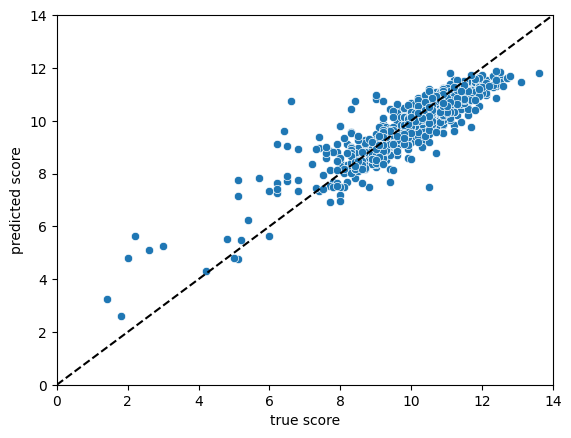

In [42]:
g = sns.scatterplot(x=TestY,y=PredY)
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((0,14))
g.set_xlim((0,14))
g = sns.lineplot(x=[0,14],y=[0,14],color='black')
g.lines[0].set_linestyle("--")

## Fine-grained features

In [69]:
x2 = []
with open('features/final-winter-fine.csv') as f:
    raw = f.readlines()[1:]

In [70]:
for i in range(len(raw)):
    l = raw[i]
    l = l.rstrip('\n').split(',')[2:]
    l = [float(i) for i in l]
    if i in list(d.index):
        x2.append(np.array(l,dtype=float).reshape(143))
    else:
        x2.append([0])

#### Create train and test data

In [143]:
TrainX,TestX = [x2[i] for i in trainIn],[x2[i] for i in testIn]
TrainY,TestY = d['score'][trainIn],d['score'][testIn]

#### Fit the model and get predictions

In [144]:
model = xgb.XGBRegressor(learning_rate=0.042)
#model = linear_model.LinearRegression()
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
PredTrainY = model.predict(TrainX)

#### Performance evaluation

In [141]:
mean_squared_error(TestY,PredY,squared=False),explained_variance_score(TestY,PredY),r2_score(TestY,PredY)

(0.7762629207348325, 0.6917458985086575, 0.6849835063773002)

In [142]:
mean_squared_error(TrainY,PredTrainY,squared=False),explained_variance_score(TrainY,PredTrainY),r2_score(TrainY,PredTrainY)

(0.48263699245617814, 0.882072560705789, 0.8717369092472085)

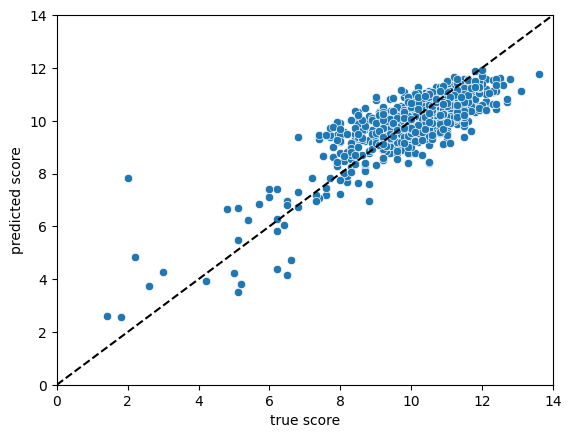

In [79]:
g = sns.scatterplot(x=TestY,y=PredY)
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((0,14))
g.set_xlim((0,14))
g = sns.lineplot(x=[0,14],y=[0,14],color='black')
g.lines[0].set_linestyle("--")

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

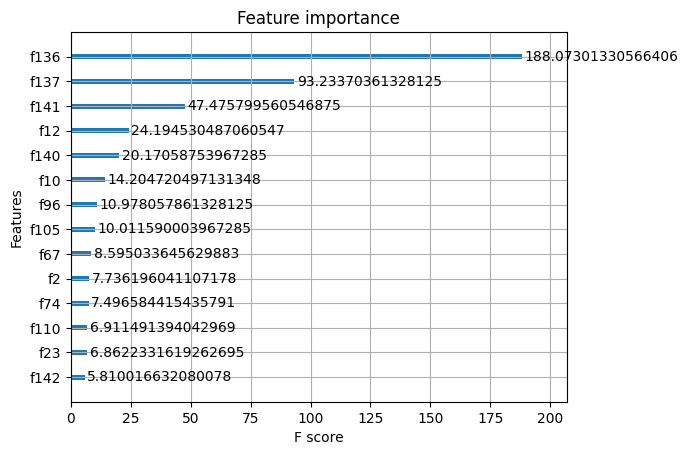

In [152]:
xgb.plot_importance(model,max_num_features=14,importance_type='gain')

#### 14 best fine-grained features

In [165]:
best_features=[136,137,141,12,140,10,96,105,67,2,74,110,23,142]
x_2best = []
for sample in x2:
    if len(sample) >1:
        x_2best.append([sample[i] for i in best_features])
    else:
        x_2best.append([])

In [166]:
TrainX,TestX = [x_2best[i] for i in trainIn],[x_2best[i] for i in testIn]
TrainY,TestY = d['score'][trainIn],d['score'][testIn]

In [167]:
model = xgb.XGBRegressor(learning_rate=0.042)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
PredTrainY = model.predict(TrainX)

In [168]:
mean_squared_error(TestY,PredY,squared=False),explained_variance_score(TestY,PredY),r2_score(TestY,PredY)

(0.804661127998026, 0.6681715805447928, 0.6615132658878927)

### Mean pooling + fine-grained

In [56]:
x3 = []
for i in range(3830):
    a = np.concatenate((x1[i],x2[i]))
    x3.append(a)

#### Create train and test data

In [135]:
TrainX,TestX = [x3[i] for i in trainIn],[x3[i] for i in testIn]
TrainY,TestY = d['score'][trainIn],d['score'][testIn]

#### Fit the model and get predictions

In [136]:
model = xgb.XGBRegressor(learning_rate=0.042)
#model = linear_model.LinearRegression()
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
PredTrainY = model.predict(TrainX)

#### Performance evaluation

In [137]:
mean_squared_error(TestY,PredY,squared=False),explained_variance_score(TestY,PredY),r2_score(TestY,PredY)

(0.5346453912128105, 0.862882991547073, 0.8505667423914726)

In [138]:
mean_squared_error(TrainY,PredTrainY,squared=False),explained_variance_score(TrainY,PredTrainY),r2_score(TrainY,PredTrainY)

(0.2405520907248183, 0.9787344089063671, 0.9681375798144063)

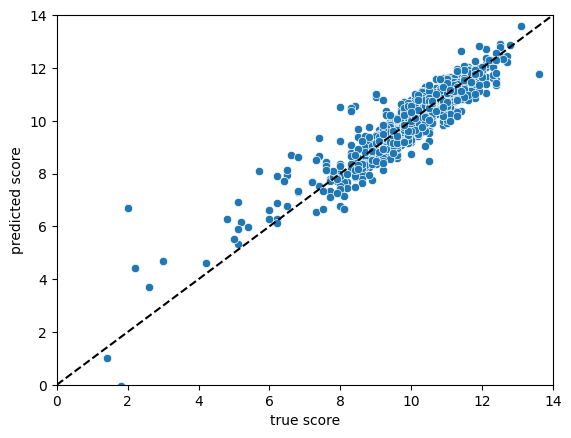

In [90]:
g = sns.scatterplot(x=TestY,y=PredY)
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((0,14))
g.set_xlim((0,14))
g = sns.lineplot(x=[0,14],y=[0,14],color='black')
g.lines[0].set_linestyle("--")

#### Linear regression for fine-grained features

In [179]:
df = pd.read_csv('features/final-winter-fine.csv')
df['score'] = d['score']
df = df.loc[df['score']>0]

In [183]:
features = [df.columns[2:-1][i] for i in best_features]

In [191]:
model = pg.linear_regression(df[features],df['score'])
model['sig'] = [model['pval'][i]<0.05 for i in range(len(model))]

#### selecting significant features

In [193]:
pg.linear_regression(df[model.loc[model['sig']== True]['names'][1:]],df['score'],relimp=True)

C:\Users\GIGA\AppData\Local\Temp\ipykernel_15116\564392207.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pg.linear_regression(df[model.loc[model['sig']== True]['names'][1:]],df['score'],relimp=True)


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,4.892834,0.114095,42.883929,0.000000e+00,0.525884,0.524628,4.669141,5.116528,NaN,NaN
1,adj_var,0.725540,0.038012,19.087112,1.316687e-77,0.525884,0.524628,0.651013,0.800066,0.122947,23.379154
2,verb_var,0.663758,0.039252,16.910009,6.849537e-62,0.525884,0.524628,0.586800,0.740716,0.116794,22.209010
3,auxpass,0.108258,0.022508,4.809761,1.570141e-06,0.525884,0.524628,0.064129,0.152387,0.016076,3.056947
4,dep,-0.334062,0.022651,-14.748496,6.626239e-48,0.525884,0.524628,-0.378471,-0.289654,0.032165,6.116316
5,Perf/sent,-1.083625,0.157955,-6.860350,7.994503e-12,0.525884,0.524628,-1.393310,-0.773940,0.007678,1.460102
6,noun/sent,0.251196,0.021525,11.669822,6.144209e-31,0.525884,0.524628,0.208993,0.293398,0.038757,7.369931
7,ADP,0.019878,0.003059,6.497228,9.249460e-11,0.525884,0.524628,0.013879,0.025876,0.077121,14.665068
8,mark,0.087819,0.007160,12.264523,6.169209e-34,0.525884,0.524628,0.073780,0.101857,0.040912,7.779673
9,advmod/sent,0.037700,0.053482,0.704919,4.809042e-01,0.525884,0.524628,-0.067156,0.142556,0.013024,2.476667


### Large-grained features

In [63]:
with open('features/final-winter-l2sca.txt') as f:
    l2 = f.readlines()[1:]
xl = dict()
for l in l2:
    i = int(l.split(',')[0].split('.')[0])
    feat = l.rstrip('\n').split(',')[-14:]
    feat = [float(s) for s in feat]
    xl[i] = feat
x4 = []
for i in range(3830):
    x4.append(xl[i])

In [64]:
TrainX,TestX = [x4[i] for i in trainIn],[x4[i] for i in testIn]
TrainY,TestY = d['score'][trainIn],d['score'][testIn]

In [65]:
model = xgb.XGBRegressor(learning_rate=0.042)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
PredTrainY = model.predict(TrainX)

In [66]:
mean_squared_error(TestY,PredY,squared=False),explained_variance_score(TestY,PredY),r2_score(TestY,PredY)

(1.2691282644244657, 0.16241902636938854, 0.15797178985865445)

In [67]:
mean_squared_error(TrainY,PredTrainY,squared=False),explained_variance_score(TrainY,PredTrainY),r2_score(TrainY,PredTrainY)

(0.871248880595761, 0.5918600881598102, 0.5820301502470311)

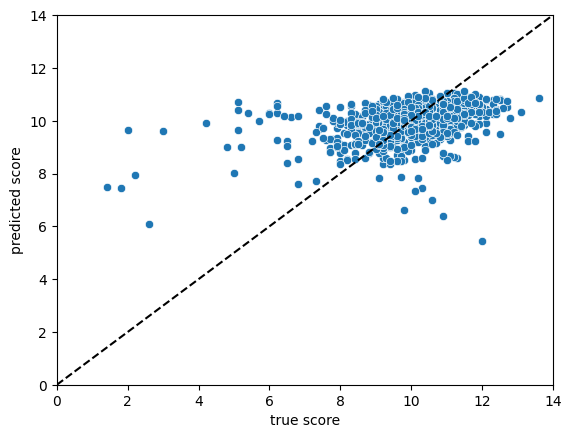

In [68]:
g = sns.scatterplot(x=TestY,y=PredY)
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((0,14))
g.set_xlim((0,14))
g = sns.lineplot(x=[0,14],y=[0,14],color='black')
g.lines[0].set_linestyle("--")

#### Linear regression

In [171]:
df = pd.DataFrame(x4)
df.columns = 'W,S,VP,C,T,DC,CT,CP,CN,MLS,MLT,MLC,C/S,VP/T,C/T,DC/C,DC/T,T/S,CT/T,CP/T,CP/C,CN/T,CN/C'.split(',')[-14:]
df['score'] = d['score']
df = df.loc[df['score'] > 0]

In [172]:
model = pg.linear_regression(df['W,S,VP,C,T,DC,CT,CP,CN,MLS,MLT,MLC,C/S,VP/T,C/T,DC/C,DC/T,T/S,CT/T,CP/T,CP/C,CN/T,CN/C'.split(',')[-14:]],df['score'])
model['sig'] = [model['pval'][i]<0.05 for i in range(len(model))]

In [173]:
model.loc[model['sig']== True]

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],sig
0,Intercept,9.799663,0.162355,60.359313,0.000000e+00,0.108459,0.105147,9.481350,10.117976,True
1,MLS,0.024622,0.008457,2.911312,3.620252e-03,0.108459,0.105147,0.008040,0.041203,True
5,VP/T,-0.209771,0.039259,-5.343264,9.669245e-08,0.108459,0.105147,-0.286742,-0.132800,True
9,T/S,-0.557950,0.081717,-6.827854,1.000510e-11,0.108459,0.105147,-0.718163,-0.397736,True
11,CP/T,-0.368380,0.115475,-3.190144,1.433686e-03,0.108459,0.105147,-0.594779,-0.141982,True
12,CP/C,1.809211,0.333533,5.424381,6.181166e-08,0.108459,0.105147,1.155288,2.463134,True
14,CN/C,0.426607,0.173242,2.462486,1.384218e-02,0.108459,0.105147,0.086949,0.766265,True


#### Selecting significant features

In [178]:
pg.linear_regression(df[model.loc[model['sig']== True]['names'][1:]],df['score'],relimp=True)

C:\Users\GIGA\AppData\Local\Temp\ipykernel_15116\564392207.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pg.linear_regression(df[model.loc[model['sig']== True]['names'][1:]],df['score'],relimp=True)


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,9.949554,0.106706,93.242518,0.000000e+00,0.095921,0.094485,9.740346,10.158761,NaN,NaN
1,MLS,0.028965,0.003324,8.714259,4.307712e-18,0.095921,0.094485,0.022448,0.035482,0.007954,8.292546
2,VP/T,-0.186403,0.020329,-9.169164,7.642291e-20,0.095921,0.094485,-0.226260,-0.146545,0.012386,12.912978
3,T/S,-0.632581,0.063709,-9.929232,5.921917e-23,0.095921,0.094485,-0.757488,-0.507673,0.011241,11.719004
4,CP/T,-0.244549,0.092782,-2.635728,8.430030e-03,0.095921,0.094485,-0.426458,-0.062641,0.005217,5.439266
5,CP/C,1.470533,0.265021,5.548737,3.074989e-08,0.095921,0.094485,0.950934,1.990132,0.021913,22.845147
6,CN/C,0.604476,0.067810,8.914199,7.497188e-19,0.095921,0.094485,0.471527,0.737424,0.037209,38.791059
